In [1]:
%%capture
!git clone https://github.com/pytorch/vision.git
%cd vision
%cp references/detection/utils.py ../
%cp references/detection/transforms.py ../
%cp references/detection/coco_eval.py ../
%cp references/detection/engine.py ../
%cp references/detection/coco_utils.py ../
%cd ..
    

In [2]:
%%capture
!pip install pycocotools

In [3]:
import sys
import math
import time
import random
import os, numpy as np
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.metrics import average_precision_score
import torch.utils.data as data
from scipy.sparse import csr_matrix
from PIL import Image
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib import patches
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
import warnings
warnings.filterwarnings('ignore')

In [4]:
# VOC dataloader
VOC_CLASSES = ('__background__', 'aeroplane', 'bicycle', 'bird', 'boat',
                        'bottle', 'bus', 'car', 'cat', 'chair',
                        'cow', 'diningtable', 'dog', 'horse',
                        'motorbike', 'person', 'pottedplant',
                        'sheep', 'sofa', 'train', 'tvmonitor')


class VocDataset(data.Dataset):
    def __init__(self, data_path, dataset_split, transform, random_crops=0):
        self.data_path = data_path
        self.transform = transform
        self.random_crops = random_crops
        self.dataset_split = dataset_split

        self.__init_classes()
        self.names, self.labels, self.box_indices, self.label_order, self.bbox_all = self.__dataset_info()

    def __getitem__(self, index):
        x = Image.open(self.data_path + '/JPEGImages/' + self.names[index] + '.jpg')

        scale = np.random.rand() * 2 + 0.25
        w = int(x.size[0] * scale)
        h = int(x.size[1] * scale)
        if min(w, h) < 227:
            scale = 227 / min(w, h)
            w = int(x.size[0] * scale)
            h = int(x.size[1] * scale)

        if self.random_crops == 0:
            x = self.transform(x)
        else:
            crops = []
            for i in range(self.random_crops):
                crops.append(self.transform(x))
            x = torch.stack(crops)

        y = self.labels[index]
        z = np.asarray(self.box_indices[index])
#         print(z)
        area = (z[:,2]- z[:,0])*(z[:,3]-z[:,1])
        box_info = self.bbox_all[index]
        target = {}
        target['iscrowd'] = torch.from_numpy(np.zeros(len(z)))
        target["area"] = torch.from_numpy(area)
        target["image_id"] = torch.tensor([index])
        target['boxes'] = torch.from_numpy(np.asarray(self.bbox_all[index][0])).type(torch.int32)
        target['labels'] = torch.from_numpy(np.asarray(self.bbox_all[index][1])).type(torch.int64)
        return x , target

    def __len__(self):
        return len(self.names)

    def __init_classes(self):
        self.classes = VOC_CLASSES
        self.num_classes = len(self.classes)
        self.class_to_ind = dict(zip(self.classes, range(self.num_classes)))

    def __dataset_info(self):
        with open(self.data_path + '/ImageSets/Main/' + self.dataset_split + '.txt') as f:
            annotations = f.readlines()

        annotations = [n[:-1] for n in annotations]
        box_indices = []
        names = []
        labels = []
        label_order = []
        bbox_all = []
        for af in annotations:
            if len(af) != 6:
                continue
            filename = os.path.join(self.data_path, 'Annotations', af)
            tree = ET.parse(filename + '.xml')
            objs = tree.findall('object')
            num_objs = len(objs)

            boxes = np.zeros((num_objs, 4), dtype=np.int32)
            boxes_cl = np.zeros((num_objs), dtype=np.int32)
            boxes_cla = []
            temp_label = []
            
            for ix, obj in enumerate(objs):
                bbox = obj.find('bndbox')
                # Make pixel indexes 0-based
                x1 = float(bbox.find('xmin').text) - 1
                y1 = float(bbox.find('ymin').text) - 1
                x2 = float(bbox.find('xmax').text) - 1
                y2 = float(bbox.find('ymax').text) - 1

                cls = self.class_to_ind[obj.find('name').text.lower().strip()]
                boxes[ix, :] = [x1, y1, x2, y2]
                boxes_cl[ix] = cls
                boxes_cla.append(boxes[ix, :])
                temp_label.append(cls)
            
            bbox_cls = [boxes_cla, boxes_cl]
            bbox_all.append(bbox_cls)
            lbl = np.zeros(self.num_classes)
            lbl[boxes_cl] = 1
            labels.append(lbl)
            names.append(af)
            box_indices.append(boxes_cla)
            label_order.append(temp_label)

        return np.array(names), np.array(labels).astype(np.float32), np.array(box_indices), label_order, np.array(bbox_all)

In [5]:
## Load the dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])

test_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

ds_train = VocDataset('../input/voc-2007/VOCdevkit_2007/VOC2007/','trainval',train_transform)
ds_test = VocDataset('../input/voc-2007/VOCdevkit_2007/VOC2007test/','test', test_transform)

In [6]:
print(len(ds_train), len(ds_test))

5011 4952


Since there were only 2500 training data points,so we augmented training and validation data points to train thw model in more efficient way.

In [7]:
batch_size = 5

train_loader = torch.utils.data.DataLoader(dataset=ds_train,
                                               batch_size=batch_size, 
                                               shuffle=False,
                                               num_workers=4,
                                               collate_fn=lambda x:list(zip(*x)))

test_loader = torch.utils.data.DataLoader(dataset=ds_test,
                                               batch_size=batch_size, 
                                               shuffle=False,
                                               num_workers=4,
                                               collate_fn=lambda x:list(zip(*x)))

In [8]:

def plot_bbox(images, labels, k,std=1,mean=0):
    for i in range(k):
        
        figure = plt.figure(figsize=(8,6))
        images=list(images)
        labels=list(labels)
        out=images[i]
        inp=out.cpu().numpy().transpose((1,2,0))
        
        gray = 0.2126*inp[:,:,0]+0.7152*inp[:,:,1]+0.0722*inp[:,:,2]
        plt.imshow(gray, cmap =plt.cm.gray)
        inp=np.array(std)*inp+np.array(mean)
        inp=np.clip(inp,0,1) 
        
        ax = plt.gca()
        l=labels[i]['boxes'].cpu().numpy()
        label = labels[i]['labels'].cpu().numpy()
        l[:,2]=l[:,2]-l[:,0]
        l[:,3]=l[:,3]-l[:,1]
        for j in range(len(l)):
            ax.text(l[j][0],l[j][1],VOC_CLASSES[label[j]], fontsize =14, color ='r')
            ax.add_patch(patches.Rectangle((l[j][0],l[j][1]),l[j][2],l[j][3],linewidth=2,edgecolor='green',facecolor='none'))
        plt.show()

# view(train_loader,2)

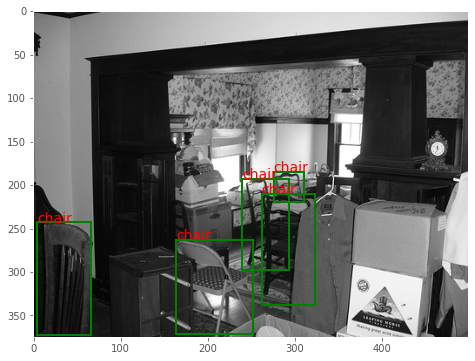

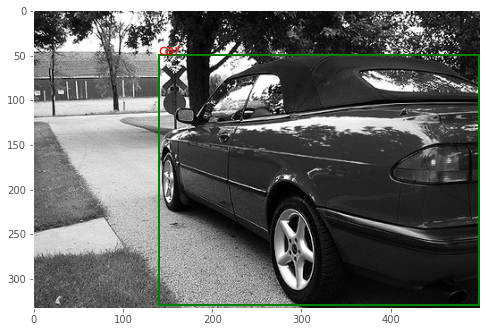

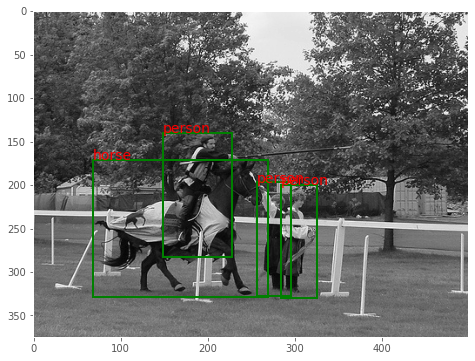

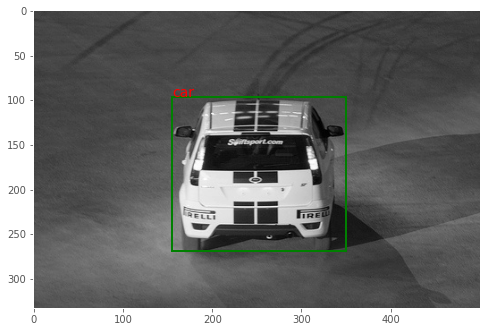

In [9]:
# Let's plot the bbox on the input image
images, labels= next(iter(train_loader))
plot_bbox(images, labels ,4 )

In [10]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

#take pre-trained faster rcnn model from pytorch and tune it on our dataset
NUM_CLASSES = 21
def initialize_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)
    model=model.to(device)

    return model
   

In [11]:
 torch.cuda.empty_cache()

In [12]:
from engine import train_one_epoch, evaluate

num_epochs = 20
model = initialize_model()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                    momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=5,
                                                   gamma=0.1)
loss = []
loss_cl = []
loss_bb_regr = []
loss_rpn_regr = []
loss_objectness = []

def train(model, num_epochs, train_loader, test_loader, optimizer):
    
    for epoch in range(1,num_epochs+1):
        
        fb = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=100) #training on train data
        loss.append(str(fb.meters['loss'])[8:14])
        loss_cl.append(str(fb.meters['loss_classifier'])[8:14])
        loss_bb_regr.append(str(fb.meters['loss_box_reg'])[8:14])
        loss_rpn_regr.append(str(fb.meters['loss_rpn_box_reg'])[8:14])
        loss_objectness.append(str(fb.meters['loss_objectness'])[8:14])
        
        lr_scheduler.step()
        
        evaluate(model, test_loader, device=device) #evaluation on test data


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [13]:
train(model, num_epochs, train_loader, test_loader, optimizer)

Epoch: [1]  [   0/1003]  eta: 0:39:37  lr: 0.005000  loss: 4.2301 (4.2301)  loss_classifier: 3.7569 (3.7569)  loss_box_reg: 0.0500 (0.0500)  loss_objectness: 0.3883 (0.3883)  loss_rpn_box_reg: 0.0349 (0.0349)  time: 2.3707  data: 0.3519  max mem: 8213
Epoch: [1]  [ 100/1003]  eta: 0:14:27  lr: 0.005000  loss: 0.6679 (0.7513)  loss_classifier: 0.3344 (0.3919)  loss_box_reg: 0.3083 (0.2818)  loss_objectness: 0.0153 (0.0515)  loss_rpn_box_reg: 0.0165 (0.0262)  time: 0.9595  data: 0.0170  max mem: 9315
Epoch: [1]  [ 200/1003]  eta: 0:12:47  lr: 0.005000  loss: 0.5065 (0.6701)  loss_classifier: 0.2345 (0.3336)  loss_box_reg: 0.2289 (0.2762)  loss_objectness: 0.0136 (0.0364)  loss_rpn_box_reg: 0.0165 (0.0238)  time: 0.9510  data: 0.0164  max mem: 9315
Epoch: [1]  [ 300/1003]  eta: 0:11:13  lr: 0.005000  loss: 0.4708 (0.6089)  loss_classifier: 0.2014 (0.2919)  loss_box_reg: 0.2292 (0.2646)  loss_objectness: 0.0118 (0.0296)  loss_rpn_box_reg: 0.0173 (0.0228)  time: 0.9882  data: 0.0168  max me

In [14]:
torch.save(model.state_dict(), './model.pth')

In [15]:
#reload the model
model.load_state_dict(torch.load('./model.pth'))

<All keys matched successfully>

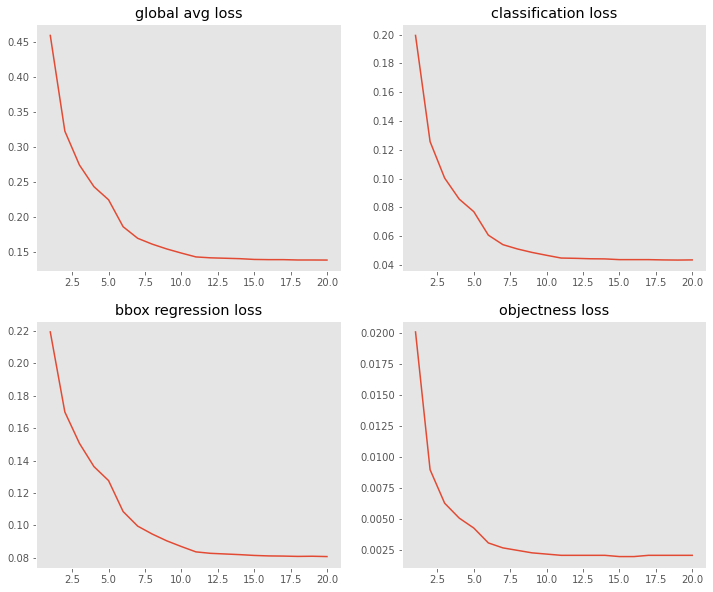

In [16]:
 # Plot the cureves for all the losses
_, ax = plt.subplots(2,2, figsize = (12,10))
loss = list(map(float, loss))
loss_cl = list(map(float, loss_cl))
loss_bb_regr = list(map(float, loss_bb_regr))
loss_rpn_regr = list(map(float, loss_rpn_regr))
loss_objectness = list(map(float, loss_objectness)) 
x= np.arange(1,num_epochs+1)

ax[0,0].plot(x, loss)
ax[0,0].set_title('global avg loss')
ax[0,1].plot(x, loss_cl)
ax[0,1].set_title('classification loss')
ax[1,0].plot(x, loss_bb_regr)
ax[1,0].set_title('bbox regression loss')
ax[1,1].plot(x, loss_objectness )
ax[1,1].set_title('objectness loss')
plt.show()


#### These are some of the outputs of the Faster-RCNN Model

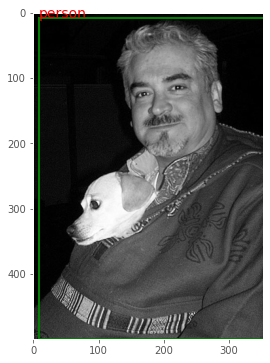

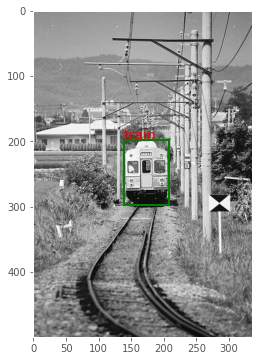

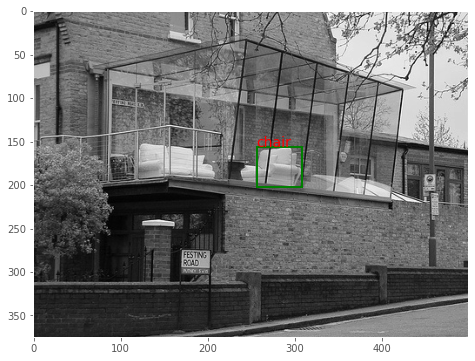

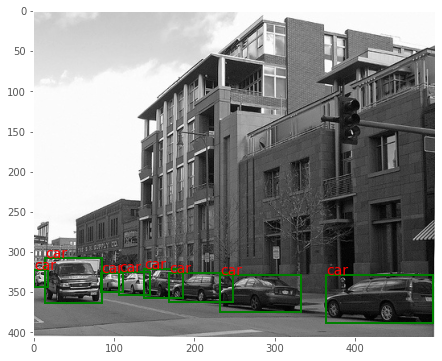

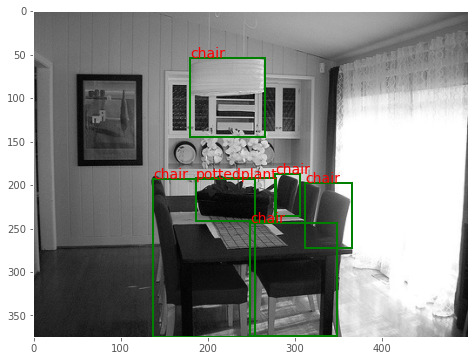

In [17]:
# plot the prediction point and bonding boxes
model.eval()
with torch.no_grad():
    images, targets = next(iter(test_loader))

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    op = model(images)
    
    for i, ops in enumerate(op):
        box = ops['boxes']
        score = ops['scores']
        idx = ops['labels']
        
        #Non maximum supression with IoU threshold 0.28
        flag = torchvision.ops.nms(box, score, 0.28)
        box = box[flag]
        labels = idx[flag]
        op_dict = {}
        op_dict['boxes'] = box
        op_dict['labels'] = labels
        plot_bbox([images[i]], [op_dict], 1 )
